In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

import pandas as pd
import docx
import os
import re

device = 'cuda'

/home/ubuntu/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#word preprocessing functions

import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

russian_stopwords = stopwords.words("russian")

russian_stopwords.append('российской')
russian_stopwords.append('федерации')
russian_stopwords.append('федерального')
russian_stopwords.append('настоящих')
russian_stopwords.append('соответствии')
russian_stopwords.append('также')
russian_stopwords.append('рф')
russian_stopwords.append('ред')

russian_stopwords.append('субсидии')
russian_stopwords.append('предоставления')


def lowercase(text):
    return str(text).lower()

def clean_symb(text):
    return re.sub(r'[^\w]', ' ', text)

def clear_token(text):
    return word_tokenize(text)

def clean_stopwords(token):
    return ' '.join([i for i in token.split(' ') if i not in russian_stopwords])

def clean_stem(token):
    return [st.stem(i) for i in token]

### combo 3 prev
def make_clean(s):
    return ' '.join(clean_stem(clean_stopwords(clear_token(s))))

In [3]:
#find all docs

data_path = './data/Документы/'
documents = os.listdir(data_path)
documents = [data_path+d for d in documents]
len(documents)

162

In [4]:
#load and parse doc functions

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize


def get_text(filename):
    doc = docx.Document(filename)
    fullText = ''
    for para in doc.paragraphs:
         for run in para.runs:
            fullText+=run.text
            fullText+='\n'
    return fullText

def split_text(text):
    texts, groups = [],[]
    regt = re.findall(r"{(.*?)}(.*?){(.*?)}",text.replace('\n',''))
    for t in regt:
        if t[0]==t[-1]:
            texts.append(t[1])
            groups.append(int(t[0]))
        else:
            print(t)
            
    return texts, groups

In [5]:
#load data

all_text, all_groups, doc_paths, doc_names = [],[],[],[]
for d in documents:
    if 'ipynb' not in d:
        text = get_text(d)
        texts,groups = split_text(text)
        all_text.extend(texts)
        all_groups.extend(groups)
        doc_paths.extend([d for a in range(len(texts))])
        doc_names.extend([d.split('/')[-1] for a in range(len(texts))])

('36', '42. ', '37')
('37', ' (в ред.  Правительства РФ от 04.05.2021 N 699) 43. ', '38')
('38', '    48.', '7')
('10', '6. ', '24')
('24', ' 7. ', '11')
('11', '8. ', '10')
('13', 'м) ', '10')
('10', '(пп. "о" в ред.  Правительства РФ от 16.08.2021 N 1337)9. ', '13')
('13', '(в ред.  Правительства РФ от 16.08.2021 N 1337)12. ', '11')
('11', ' ', '24')
('24', ' ', '17')
('17', '14. ', '21')
('21', '15. ', '15')
('15', '(в ред.  Правительства РФ от 16.08.2021 N 1337)16. ', '22')
('22', ' 17. ', '21')
('21', '18. ', '28')
('28', ' ', '12')
('12', ' ', '30')
('28', '', '30')
('30', 'ж) утратил силу. -  Правительства РФ от 16.08.2021 N 1337.19. ', '23')
('23', ' 20. ', '13')
('12', ' 21. ', '13')
('13', ' 22. ', '22')
('22', '23. ', '11')
(' 11', ' 24. ', '11')
('11', '25. ', '21')
('21', 'ж) утратил силу. -  Правительства РФ от 16.08.2021 N 1337.26. ', '24')
('24', ' 28. ', '27')
('27', ' ', '22')
('22', '29. ', '24')
('24', ' 31. ', '37')
('37', ' (в ред.  Правительства РФ от 16.08.2021 

In [6]:
#load documents
#apply preprocessing to documents

df = pd.DataFrame([doc_paths, doc_names,all_text, all_groups]).T
df.columns = ['path','doc','text','type']
df['r_text']='r'
df['r_text'] = df.text.apply(lowercase)
df['r_text'] = df.r_text.apply(clean_symb)
df['r_text'] = df.r_text.apply(lambda x:''.join([a for a in x if not a.isdigit()]))
df['r_text'] = df.r_text.apply(lambda x:' '.join([a for a in x.split(' ') if len(a)>1]))
df['r_text'] = df.r_text.apply(clean_stopwords)
df['text_size'] = df['text'].apply(lambda x: len(x.strip()))
df['is_text'] = df.r_text.apply(lambda x:x.strip().isdigit())
df = df[~df.is_text]
df = df[df['text_size']>5]
df = df.reset_index(drop=True)
df.shape
df.type = df.type.astype(int)-1

In [7]:
#show most popular words in datset

all_words = np.hstack([np.array(a) for a in df.r_text.apply(lambda x:[a for a in x.split(' ') if len(a)>0]).values])
pd.Series(all_words).value_counts()[:10]

правил            3588
организации       2263
отбора            2042
соглашения        1940
предоставлении    1747
результата        1578
гранта            1556
министерством     1544
дня               1360
заявок            1344
dtype: int64

In [8]:
#split data to train/test

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

X_data, X_val, y_data, y_val = train_test_split(list(df['r_text']), list(df['type']), test_size=0.1, random_state=42)

In [9]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

from bert_dataset import CustomDataset

In [11]:
#Bert Classifier class

class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
    
    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=8, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=8, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
            
    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    
    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in self.valid_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss
    
    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        self.model = torch.load(self.model_save_path)
    
    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [12]:
#make bert

classifier = BertClassifier(
        model_path='sberbank-ai/ruBert-base',
        tokenizer_path='sberbank-ai/ruBert-base',
        n_classes=39,
        epochs=10,
        model_save_path='bert_fit_models/bert.pt'
)

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

In [13]:
#prepare data to classification
classifier.preparation(
        X_train=list(X_data),
        y_train=list(y_data),
        X_valid=list(X_val),
        y_valid=list(y_val),
    )

In [13]:
#train
classifier.train()

Epoch 1/10


100%|███████████████████████████████████████| 1960/1960 [24:31<00:00,  1.33it/s]


Train loss 1.6872646148563648 accuracy 0.5666815485681486
Val loss 1.412977649804649 accuracy 0.6115892139988525
----------
Epoch 2/10


100%|███████████████████████████████████████| 1960/1960 [24:32<00:00,  1.33it/s]


Train loss 1.1436501777863928 accuracy 0.6886918808597488
Val loss 1.2984553687616225 accuracy 0.6374067699368904
----------
Epoch 3/10


100%|███████████████████████████████████████| 1960/1960 [24:32<00:00,  1.33it/s]


Train loss 0.9005808831667718 accuracy 0.7508131896166848
Val loss 1.2479785930946332 accuracy 0.6666666666666666
----------
Epoch 4/10


100%|███████████████████████████████████████| 1960/1960 [24:32<00:00,  1.33it/s]


Train loss 0.7234191348244037 accuracy 0.7962242489954717
Val loss 1.2792062138062004 accuracy 0.6580608146873207
----------
Epoch 5/10


100%|███████████████████████████████████████| 1960/1960 [24:30<00:00,  1.33it/s]


Train loss 0.5877058356572703 accuracy 0.8332164041074048
Val loss 1.3536883816464778 accuracy 0.6678141135972461
----------
Epoch 6/10


100%|███████████████████████████████████████| 1960/1960 [24:30<00:00,  1.33it/s]


Train loss 0.49206937486923547 accuracy 0.8616620957969259
Val loss 1.4424607625248236 accuracy 0.6752725186460126
----------
Epoch 7/10


100%|███████████████████████████████████████| 1960/1960 [24:25<00:00,  1.34it/s]


Train loss 0.40955075885392533 accuracy 0.8821353402640475
Val loss 1.5361568299250319 accuracy 0.6620768789443487
----------
Epoch 8/10


100%|███████████████████████████████████████| 1960/1960 [24:25<00:00,  1.34it/s]


Train loss 0.3543910782568024 accuracy 0.899292046686651
Val loss 1.6124461362428895 accuracy 0.6712564543889844
----------
Epoch 9/10


 58%|██████████████████████▌                | 1132/1960 [14:04<10:16,  1.34it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [20]:
#save best model again

torch.save(classifier.model,'bert_magnus_opum.pt')

In [10]:
#load bert and truncate last layer
#get the embeddings layer

model = torch.load('bert_opossum_best_0.6753.pt')
model = model.bert
model.to(device)
pass

#load tokenizer
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base')

In [11]:
#get token and embedding functions

def get_token(text):
    return tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

def get_embeddings(text):
    encoding = get_token(text)
    out = {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten()
      }

    input_ids = out["input_ids"].to(device)
    attention_mask = out["attention_mask"].to(device)

    outputs = model(
        input_ids=input_ids.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )
    return outputs[1].cpu().detach().numpy()[0]

In [12]:
#get embeddings from text

df['emb'] = df.r_text.progress_apply(get_embeddings)

100%|█████████████████████████████████████| 17422/17422 [10:11<00:00, 28.48it/s]


In [45]:
#split data again

X_full = np.asarray([a for a in df['emb'].values])
y_full = df['type'].values.astype(int)

X_data, X_val, y_data, y_val = train_test_split(X_full, y_full, test_size=0.1, random_state=42)

In [46]:
## check upsampling data
## permutation data


np.random.seed(77112)

class_size=833
X_data_r, y_data_r = [],[]


for d in np.unique(y_data):
    X_data_r.append(resample(X_data[y_data==d],
                 replace=True,
                 n_samples=833,
                 random_state=42))
    y_data_r.append(np.full([class_size],d))

X_data, y_data = np.vstack(X_data_r), np.hstack(y_data_r)

permutations = np.random.permutation(len(X_data))

X_data, y_data = X_data[permutations], y_data[permutations]

In [47]:
X_data.shape

(32487, 768)

0.03843947217441193


<AxesSubplot:xlabel='real'>

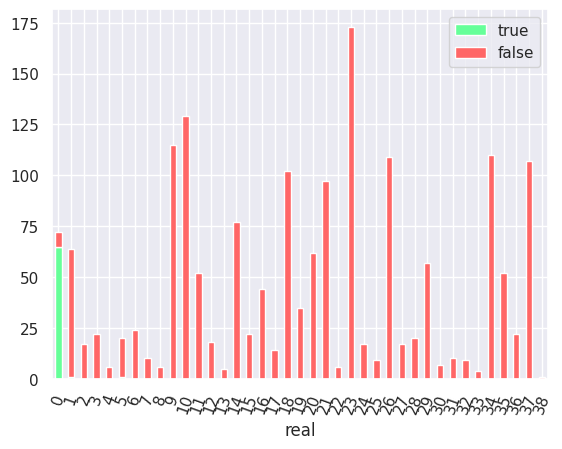

In [48]:
def classes_plot(y_val,y_pred):
    vd = pd.DataFrame([y_pred,y_val],index=['pred','real']).T
    vd_pred_true = vd[vd.pred==vd.real].groupby(by='real').count()
    vd_pred_all = vd.groupby(by='real').count()
    vd_pred = pd.concat([vd_pred_true,vd_pred_all-vd_pred_true],axis=1)
    # vd_pred.false[vd_pred.isna().iloc[:,0]]=vd.real[vd_pred.isna().iloc[:,0]].values
    vd_pred.columns = ['true','false']
    #print(vd_pred_all.pred[vd_pred.false.isna().values])
    #print(vd_pred_true.pred[vd_pred_true[vd_pred.false.isna()]])
    vd_pred.false[vd_pred.false.isna()]=vd_pred_all.pred[vd_pred.false.isna().values]
    vd_pred = vd_pred.fillna(0)
    vd_pred_sum = vd_pred.sum()
    print(vd_pred_sum.true/(vd_pred_sum.true+vd_pred_sum.false))
    return vd_pred.plot(kind='bar',stacked=True,color=['#66FF99','#ff6666'],rot=70)

classes_plot(y_val, y_pred)

0.6523235800344234


<AxesSubplot:xlabel='real'>

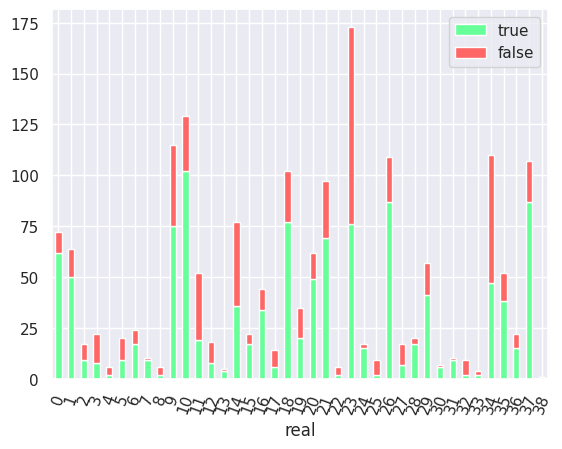

In [49]:
#fit svc

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(),
                    SVC(gamma='auto'))
clf.fit(X_data, y_data)
y_pred = clf.predict(X_val)
classes_plot(y_val, y_pred)

In [36]:
#fit random_forest

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.svm import SVC
clf = make_pipeline(RandomForestClassifier(n_jobs=-1))
clf.fit(X_data, y_data)
y_pred = clf.predict(X_val)
classes_plot(y_val, y_pred)

In [ ]:
#fit Linear SVC


from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

from sklearn.svm import LinearSVC
clf = make_pipeline(LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False))
clf.fit(X_data, y_data)
y_pred = clf.predict(X_val)
classes_plot(y_val, y_pred)